# Ensemble Learning Tutorial for Molecular Property Prediction
#### 제작 : 허종국 (hjkso1406@korea.ac.kr)
본 튜토리얼에서는 부스팅 계열의 앙상블 모델(XGBoost, LightGBM, CatBoost)을 통해 다양한 물성을 예측해보도록 하겠습니다. 각 데이터셋의 크기는 약 1000개에서 수만개까지 다양하며, 태스크는 분류와 회귀 모두 존재합니다. 데이터의 특징에 따라 어떠한 모델이 더욱 적합한지, 하이퍼파라미터에 따라 성능이 어떻게 변하는지 알아보도록 하겠습니다.
### Requiremnets
#### rdkit

__python 3.7이하__
rdkit 패키지의 설치 명령어는 Python version에 따라 다릅니다.
```
pip install rdkit 
```
__python 3.8__
```
conda install -c conda-forge rdkit
```

#### lightgbm
Windows 운영체제에서 GPU기반 LightGBM을 사용하고 싶은 경우, 아래 [링크](https://datanetworkanalysis.github.io/2019/11/13/lightgbm_gpu)의 빌드 과정을 따라해주세요!
* 설치 과정의 링크은 고려대학교 산업경영공학과 DSBA 연구실의 허재혁 연구원의 게시글임을 밝힙니다.


### Moleculenet Benchmark
뇌혈관장벽 투과성, 용해도, 전기음성도 등 화학 분자의 물성을 예측하는 것은 화학 정보학 분야에서 가장 중요한 태스크 중 하나입니다. [MoleculeNet Benchmark](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a)는 뇌혈관장벽 투과성, 용해도, 전기음성도 등 양자역학, 물리화학, 생물물리학, 생리학에 아우르는 다양한 물성에 대한 데이터셋을 제공합니다.
![Moleculenet](./images/moleculenet.png)
출처 : Wu, Z., Ramsundar, B., Feinberg, E. N., Gomes, J., Geniesse, C., Pappu, A. S., ... & Pande, V. (2018). MoleculeNet: a benchmark for molecular machine learning. Chemical science, 9(2), 513-530.


### Download Data
본 튜토리얼에서 사용하는 데이터는 MoleculeNet Benchmark의 5가지 데이터인 __BBBP, BACE, HIV, ESOL, Lipo__ 입니다. [링크](https://drive.google.com/file/d/1aDtN6Qqddwwn2x612kWz9g0xQcuAtzDE/view)를 통해 데이터를 다운받으시길 바랍니다. 혹은 `./data` 라는 폴더를 생성한 후 직접 [MoleculeNet](https://moleculenet.org/)에서 다운 받으실 수 있습니다.


* 이외에도 __qm7, ClinTox__ 등 다양한 태스크의 물성 예측 데이터를 제공하고 있습니다. 각 데이터셋의 크기, 평가지표, 태스크(분류/회귀), 스플릿 방식은 아래와 같으니 참고해주세요!
출처 : Wang, Y., Wang, J., Cao, Z., & Farimani, A. B. (2021). Molclr: Molecular contrastive learning of representations via graph neural networks. arXiv preprint arXiv:2102.10056.
![Description](./images/description.PNG)

### Load Data
#### Molecular Fingerprint란??
분자를 고정된 크기의 해쉬코드로 전환한 것을 Molecular Fingerprint라고 합니다. 본 튜토리얼에서는 rdkit에서 제공하는 __Morgan Fingerprint__ 를 통해 분자를 정형 데이터로 표현하도록 하겠습니다. Morgan Fingerprint에 대해 더 관심있고 자세한 설명을 듣고싶은 분들은
__서울대학교 제약학과 이주용 교수님__ 의 [유튜브 강의](https://www.youtube.com/watch?v=T2aHx4wVea8&t=592s)를 참고해주세요!

#### Scaffold Split이란??
스캐폴드(Scaffold)란 분자를 이루고 있는 기본적인 골격 뼈대를 의미합니다. 각 분자별로 가지고 있는 Scaffold는 같을 수도 있고 다를 수도 있습니다. 스캐폴드의 예시는 아래 그림과 같습니다.
![Scaffold](./images/scaffold.png)

물성 예측의 궁극적인 목적은 __한번도 본 적 없는 분자에 대해서 강건하고 정확한 타겟 물성을 예측하는 것__ 입니다. 따라서 물성 예측에서는 학습, 검증, 테스트 데이터에 대해 서로 다른 스캐폴드(Scaffold)를 가지는 것을 원칙으로 합니다. __utils.py__ 의 함수를 통해 데이터셋을 불러오고, 스캐폴드 별로 분자의 데이터셋을 분리하였습니다.

In [86]:
import os
import numpy as np
import pandas as pd
import random
import yaml

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import RDLogger
from utils import read_moleculenet_smiles, scaffold_split, fps_to_numpy, comb_product, TARGET_DICT, get_model_config

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from itertools import compress
warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')


def load_data(data_path: str, target: str, task: str, val_size: float=0.1, test_size: float=0.1):
    smiles_data, labels, garbages, fingerprints = read_moleculenet_smiles(data_path, target, task)
    
    train_indices, val_indices, test_indices = scaffold_split(smiles_data, val_size, test_size)
    
    train_smiles, val_smiles, test_smiles = [list(map(smiles_data.__getitem__, indices)) for indices in [train_indices, val_indices, test_indices]]
    train_labels, val_labels, test_labels = [list(map(labels.__getitem__, indices)) for indices in [train_indices, val_indices, test_indices]]
    train_fps, val_fps, test_fps = [list(map(fingerprints.__getitem__, indices)) for indices in [train_indices, val_indices, test_indices]]
    
    train_fps = fps_to_numpy(train_fps)
    val_fps = fps_to_numpy(val_fps)
    test_fps = fps_to_numpy(test_fps)
    
    data_dicts = {'smiles': [train_smiles, val_smiles, test_smiles],
                  'labels': [train_labels, val_labels, test_labels],
                  'fingerprints': [train_fps, val_fps, test_fps]}
    
    return data_dicts



## Classification with BACE Dataset
BACE 데이터셋은 1522개의 분자로 구성된 이진 분류 데이터셋입니다. 각 분자에 대해 __베타-세크리테이즈__ 라는 효소에 대해 억제성을 가지고 있는지에 대해 레이블이 되어있습니다. __베타-세크리테이즈 효소는 알츠하이머 증상을 진행시키는데 영향을 미칠 뿐만 아니라, 일부 알츠하이머 약제들의 흡수를 방해합니다. 따라서 이러한 효소를 억제하는 분자를 찾는 것은 알츠하이머 방지를 위한 신약 개발에 매우 중요하다고 할 수 있습니다!!__ 훈련 데이터에 대해 클래스 별로 3개씩 시각화를 해보겠습니다.
* 출처 : http://www.monews.co.kr/news/articleView.html?idxno=22035

BACE | Target : Class(classification)| Total 1513/1513 instances
Total Data Size 1513, about to generate scaffolds
Generating scaffold 0/1513
Generating scaffold 1000/1513
About to Sort in Scaffold Sets


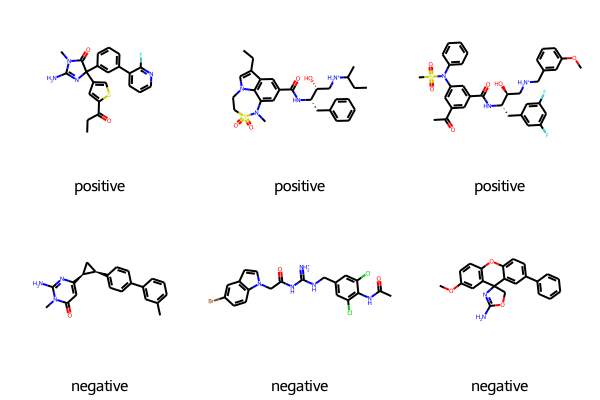

In [145]:
def confusion_matrix_plot(pred, label, data, y_col):
    cf_matrix = confusion_matrix(label, pred)
    df_cm = pd.DataFrame(cf_matrix, range(len(np.unique(label))), range(len(np.unique(label))))
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(df_cm, annot=labels, annot_kws={'size':16}, fmt='')
    plt.title(f'Data : {data}, Target : {y_col}', fontsize=16)
    plt.tight_layout()
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()

def roc_curve_plot(pred_proba, label, data, y_col):
    fpr, tpr, _ = roc_curve(label, pred_proba, pos_label=1)
    value = roc_auc_score(label, pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {value:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.title(f'Data : {data}, Target : {y_col}', fontsize=16)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
    plt.legend()
    plt.show()

data = 'BACE'
target = 'Class'
config = yaml.load(open(f'./configs/{data}_configs.yaml', 'r'), Loader=yaml.FullLoader)
data_dicts = load_data(config['data_path'], target, config['task'])

sample_smiles, sample_labels = data_dicts['smiles'][0], data_dicts['labels'][0]
pos = list(compress(sample_smiles, list(np.array(sample_labels) == 1)))
neg = list(compress(sample_smiles, list(np.array(sample_labels) == 0)))
pos_samples = random.sample(pos, 3)
neg_samples = random.sample(neg, 3)
sample_mols = [Chem.MolFromSmiles(m) for m in (pos_samples + neg_samples)]
Draw.MolsToGridImage(sample_mols, legends=['positive'] * 3 + ['negative'] * 3, molsPerRow=3)

BACE 데이터셋에 대해 XGBoost, LightGBM, CatBoost Classifier 를 활용하여 이진 분류를 수행하고 __Confusion Matrix__ 와 __ROC Curve__ 를 시각화합니다. 그리고 평가지표인 __ROC-AUC__ 를 산출합니다.
* 각 모델 별로 하이퍼파라미터 이름이 조금씩 다릅니다!! 예를 들어 XGBoost 에서 L2 규제화 상수는 __reg_lambda__ 로 정의함에 유의해주세요!!

### XGBoost

In [ ]:
xgb_classifier_params = {'learning_rate': 0.005,
                         'n_estimators': 5000,
                         'objective': 'binary:logistic',
                         'reg_lambda': 1.3,
                         'max_depth': 6,
                         'eval_metric' : ['auc'],
                         'gpu_id':0}

xgb_bace =XGBClassifier(random_state=777, **xgb_classifier_params)
xgb_bace.fit(data_dicts['fingerprints'][0], data_dicts['labels'][0], eval_set = [(data_dicts['fingerprints'][1], data_dicts['labels'][1])], verbose=500, early_stopping_rounds=200)


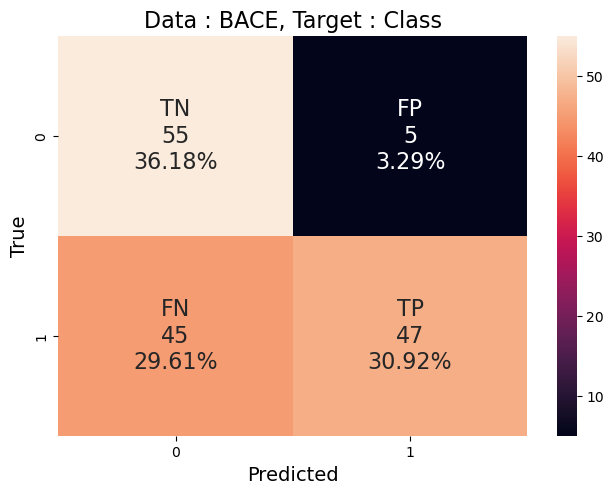

In [125]:
pred =  xgb_bace.predict(data_dicts['fingerprints'][2])
label = data_dicts['labels'][2]
confusion_matrix_plot(pred, label, data, target)

Confusion Matrix로 미루어보아 Classifier가 Negative Class 로 예측하는 경향이 좀 커보입니다. 이러한 이유는 아래 비율과 같이 데이터셋 별로 클래스 분포 차이가 다르기 때문입니다. 학습 데이터에서는 양성 데이터 비율이 더 낮기 때문에, 모델이 음성으로 예측하려는 경향이 더욱 크도록 학습 될 것입니다. 하지만 테스트 데이터에서는 양성 데이터 비율이 더욱 크기 때문에 False Negative Rate이 높게 나왔다고 추측합니다.

In [110]:
train_labels, val_labels, test_labels =data_dicts['labels']
train_ratio, val_ratio, test_ratio = [sum(l)/len(l) * 100 for l in [train_labels, val_labels, test_labels]]
for name, r in zip(['학습', '검증', '테스트'],[train_ratio, val_ratio, test_ratio]):
    print(f'{name} 데이터의 양성 비율 : {r:.2f}%')

학습 데이터의 양성 비율 : 42.56%
검증 데이터의 양성 비율 : 55.63%
테스트 데이터의 양성 비율 : 60.53%


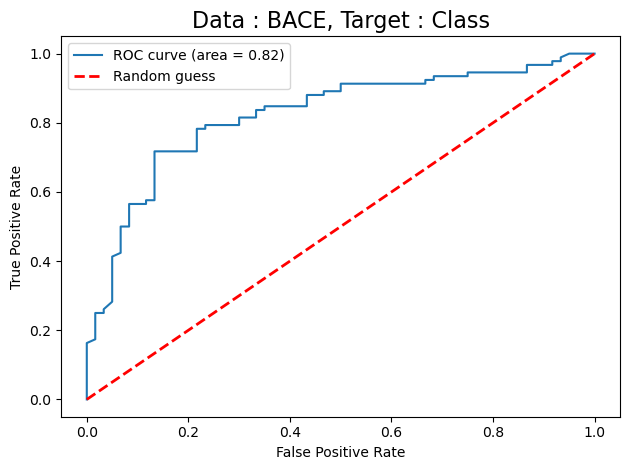

In [126]:
pred_proba = xgb_bace.predict_proba(data_dicts['fingerprints'][2])[:, 1]
label = data_dicts['labels'][2]
roc_curve_plot(pred_proba, label, data, target)

ROC 커브와 평가 지표인 AUC를 살펴보겠습니다. AUC 지표 상으로 약 0.82를 기록하였습니다. 다른 모델들과 비교하기 위해 [MolCLR](https://arxiv.org/abs/2102.10056) 논문에서 다른 지도학습 모델에 대한 성능 평가지표를 참고하였습니다. RF는 랜덤포레스트를 나타내며, RF와 SVM은 Morgan Fingerprint로 분자를 표현하였고, 나머지 모델들은 분자를 그래프로 표현하여 GNN 계열 모델을 사용하였습니다.
![BACE](./images/BACE.PNG)
BACE 데이터셋에서 랜덤포레스트가 86.7%로 가장 높은 성능을 보여주었다고 나와있습니다. XGBoost는 그에 비해 4% 정도 떨어지지만, 하이퍼파라미터 튜닝을 하지 않았음에도 __Graph Neural Network 기반 모델들에 비해 높은 성능__ 을 나타냅니다. 심지어 __SchNet__ 과 __MGCN__ 의 경우 분자 데이터 특성에 맞도록 3D Information 정보를 입력하는 모델이며 __D-MPNN__ 도 분자 데이터에 맞게 MessagePassing 을 변형한 모델입니다. 분자 데이터에 특화된 GNN 기반 모델에 비해 랜덤포레스트와 부스팅 계열 모델이 더욱 높은 성능을 보임에 따라, __BACE 데이터셋은 분자를 그래프로 표현하는 것보다 Fingerprint 방식으로 표현하는 것이 더욱 적합하다__ 는 것을 알 수 있습니다.

### LightGBM

In [ ]:
lgbm_classifier_params = {'max_depth': 6,
                          'learning_rate': 0.005,
                          'n_estimators': 5000,
                          'objective': 'binary',
                          'reg_lambda': 1.3,
                          'metric' : ['auc'],
                          'device_type' : 'gpu'}

lgbm_bace = LGBMClassifier(random_state=777, **lgbm_classifier_params)
lgbm_bace.fit(data_dicts['fingerprints'][0], data_dicts['labels'][0], eval_set = [(data_dicts['fingerprints'][1], data_dicts['labels'][1])], verbose=500, early_stopping_rounds=200)

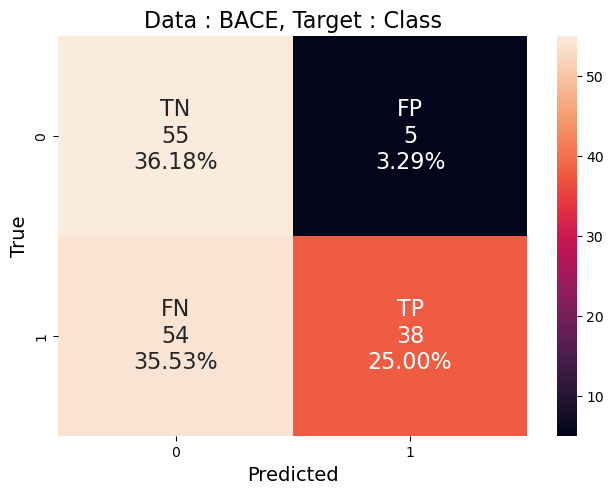

In [130]:
pred =  lgbm_bace.predict(data_dicts['fingerprints'][2])
label = data_dicts['labels'][2]
confusion_matrix_plot(pred, label, data, target)

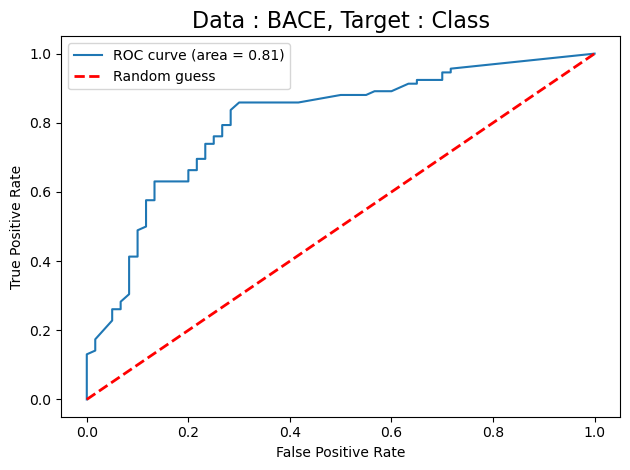

In [131]:
pred_proba = lgbm_bace.predict_proba(data_dicts['fingerprints'][2])[:, 1]
label = data_dicts['labels'][2]
roc_curve_plot(pred_proba, label, data, target)

LightGBM의 경우 XGBoost에 비해 AUC는 0.1밖에 차이가 나지 않지만 False Negative 비율이 XGBoost에 비해 5% 높다는 것을 알 수 있습니다. 하지만 반복 실험과 하이퍼 파라미터 튜닝을 진행하지 않았기 때문에, XGBoost가 클래스 불균형, 혹은 클래스 비율의 변형에 더욱 강건하다고 단정 짓기는 어려울 것 같습니다.

### CatBoost
* CatBoost에서 L2 규제화 상수가 XGBoost와 LightGBM과 달리 __l2_leaf_reg__ 임을 유의해주세요!

In [132]:
catboost_classifier_params = {'max_depth': 6,
                              'learning_rate': 0.005,
                              'n_estimators': 5000,
                              'l2_leaf_reg': 1.3,
                              'eval_metric' : 'AUC',
                              'task_type' : 'GPU',
                              'devices':'0'}

cat_bace = CatBoostClassifier(random_state=777, **catboost_classifier_params)
cat_bace.fit(data_dicts['fingerprints'][0], data_dicts['labels'][0], eval_set = [(data_dicts['fingerprints'][1], data_dicts['labels'][1])], verbose=500, early_stopping_rounds=200)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6671997	best: 0.6671997 (0)	total: 31.2ms	remaining: 2m 35s
500:	test: 0.7447583	best: 0.7484897 (364)	total: 21.6s	remaining: 3m 14s
bestTest = 0.7484897077
bestIteration = 364
Shrink model to first 365 iterations.


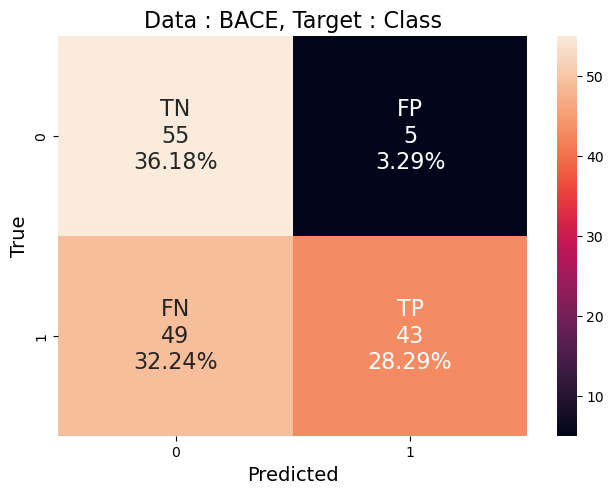

In [133]:
pred =  cat_bace.predict(data_dicts['fingerprints'][2])
label = data_dicts['labels'][2]
confusion_matrix_plot(pred, label, data, target)

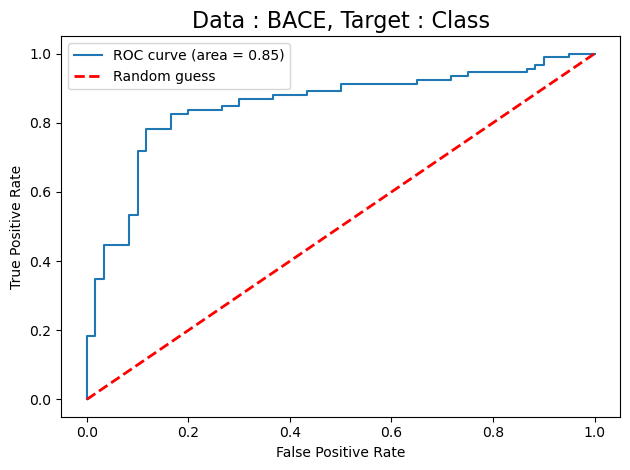

In [134]:
pred_proba = cat_bace.predict_proba(data_dicts['fingerprints'][2])[:, 1]
label = data_dicts['labels'][2]
roc_curve_plot(pred_proba, label, data, target)

CatBoost의 Confusion Matrix와 ROC Curve 및 AUC 지표 값은 위와 같습니다. 주목해야할 점은 __CatBoost가 XGBoost에 비해 FN이 더 높고 TP가 더 낮은 반면 ROC-AUC 스코어가 0.4 더 높다는 것입니다!__ (TP와 FP는 세 모델 모두 동일합니다. 즉 표기하지는 않았지만, F1-Score가 XGBoost가 더 높은 반면 ROC-AUC 측면에서는 CatBoost가 우세합니다.) 이는 CatBoost가 비록 미세하게 오분류를 진행하긴하지만, __각 예측에 대해서 Confidence가 더 높다는 뜻입니다.__

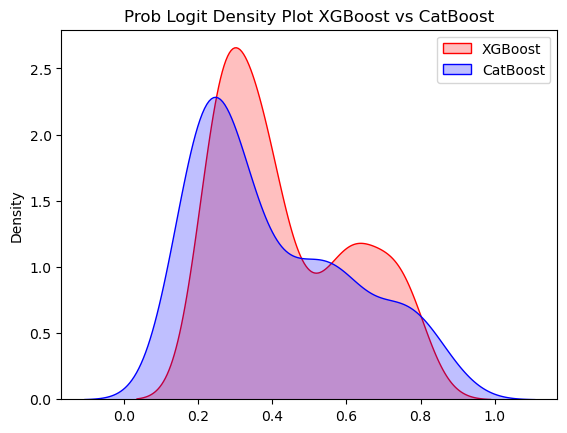

In [141]:
cat_proba = cat_bace.predict_proba(data_dicts['fingerprints'][2])[:, 1]
xgb_proba = xgb_bace.predict_proba(data_dicts['fingerprints'][2])[:, 1]
fig = sns.kdeplot(xgb_proba, shade=True, color='red', label='XGBoost')
fig = sns.kdeplot(cat_proba, shade=True, color='blue', label='CatBoost')
plt.title('Prob Logit Density Plot XGBoost vs CatBoost')
plt.legend()
plt.show()

두 모델에 대한 테스트 데이터의 logit의 density plot을 보면 알 수 있듯이, __XGBoost의 예측 확률이 더 중앙에 밀집되있습니다.__ 반면 __CatBoost는 XGBoost에 비해 0과 1 쪽(극단)에 대한 빈도가 더욱 높습니다.__ MoleculeNet Benchmark에서는 분류 태스크에 대해서 F1-Score보다는 ROC-AUC를 중점적으로 봅니다. 따라서 __F1-score는 XGBoost가 조금 더 높지만, CatBoost가 더욱 적합하다__ 고 할 수 있습니다.

## Regression with Lipo Dataset
Lipo 데이터는 회귀 데이터입니다. 4200개의 분자에 대해 __옥탄올-물 분배계수__ 를 예측하는 것입니다. 해당 계수는 분자가 물에 잘 녹는지를 판단하는 친수성과 반대의 의미를 가진 __Lipophilicity(친유성)__ 을 판단하는 지표중 하나입니다. 해당 데이터 또한 Scaffold에 따라 데이터를 스플릿하도록 하겠습니다.

In [148]:
def prediction_target_plot(pred, label, data, y_col):
    plt.figure(figsize=(8, 8))
    plt.scatter(pred, label, c='cyan')
    plt.xlabel('prediction')
    plt.ylabel('label')
    
    max = np.max(np.concatenate((pred, label), axis=None))
    min = np.min(np.concatenate((pred, label), axis=None))
    plt.plot([min, max], [min, max], c='skyblue')
    plt.title(f'Data : {data}, Target : {y_col}', fontsize=16)
    plt.tight_layout()
    plt.show()

data = 'Lipo'
target = 'exp'
config = yaml.load(open(f'./configs/{data}_configs.yaml', 'r'), Loader=yaml.FullLoader)
data_dicts = load_data(config['data_path'], target, config['task'])

LIPOPHILICITY | Target : exp(regression)| Total 4200/4200 instances
Total Data Size 4200, about to generate scaffolds
Generating scaffold 0/4200
Generating scaffold 1000/4200
Generating scaffold 2000/4200
Generating scaffold 3000/4200
Generating scaffold 4000/4200
About to Sort in Scaffold Sets


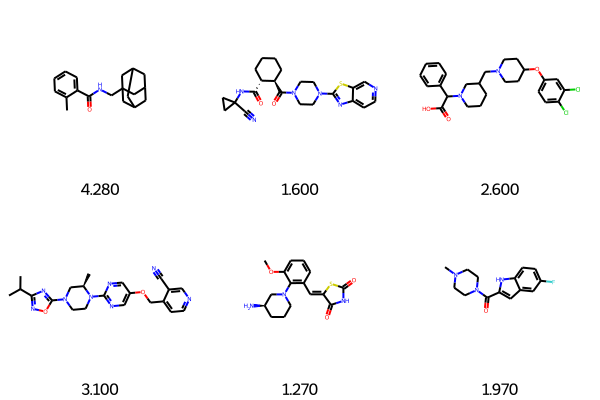

In [150]:
sample_smiles, sample_labels = data_dicts['smiles'][0], data_dicts['labels'][0]
sample_idx = random.sample(range(len(sample_smiles)), 6)
sample_smiles = [sample_smiles[i] for i in sample_idx]
sample_labels = [sample_labels[i] for i in sample_idx]
sample_labels = [str(f'{v:.3f}') for v in sample_labels]
sample_mols = [Chem.MolFromSmiles(m) for m in sample_smiles]
Draw.MolsToGridImage(sample_mols, legends=sample_labels, molsPerRow=3)

이번에도 XGBoost, LightGBM, CatBoost의 회귀 모델로 Lipo 데이터를 예측해보겠습니다. 평가지표는 __RMSE__ 를 활용합니다.

### XGBoost

In [ ]:
xgb_regressor_params = {'learning_rate': 0.005,
                        'n_estimators': 5000,
                        'objective': 'reg:squarederror',
                        'reg_lambda': 1.3,
                        'max_depth': 6,
                        'eval_metric' : ['rmse'],
                        'gpu_id':0}

xgb_lipo =XGBRegressor(random_state=777, **xgb_regressor_params)
xgb_lipo.fit(data_dicts['fingerprints'][0], data_dicts['labels'][0], eval_set = [(data_dicts['fingerprints'][1], data_dicts['labels'][1])], verbose=500, early_stopping_rounds=200)

In [154]:
pred = xgb_lipo.predict(data_dicts['fingerprints'][2])
label = data_dicts['labels'][2]
rmse = mean_squared_error(label, pred, squared=False)
print(f'XGB Regressor for FreeSolv(expt) | {rmse:.4f}')

XGB Regressor for FreeSolv(expt) | 0.9126


아래 테이블은 나머지 비교 방법론들에 대한 지표 값을 나타내며, MolCLR 논문에서 발췌하였음을 다시 한번 밝힙니다.
![Lipo](./images/Lipo.png)
XGBoost는 RMSE 0.91을 기록하였으며, 이번에는 BACE와 달리 __fingerprint 기반 모델과 graph 기반 모델 의 큰 차이가 없음__ 을 알 수 있습니다.

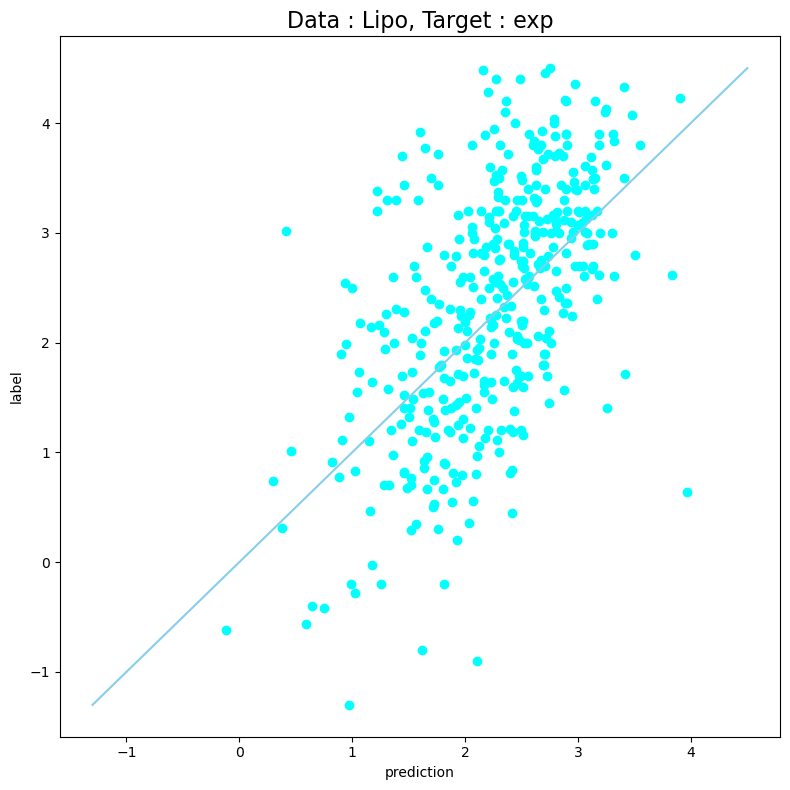

In [155]:
prediction_target_plot(pred, label, data, target)

위 그림은 테스트 데이터에 대해 XGBoost의 prediction-target plot을 그린 것입니다. 특이한 점은 prediction 값이 2~3 사이에 집중적으로 분포되있다는 것을 알 수 있습니다. 이러한 이유의 원인은 아래 그림과 같이 데이터셋 별 타겟의 분포를 보면 알 수 있습니다.

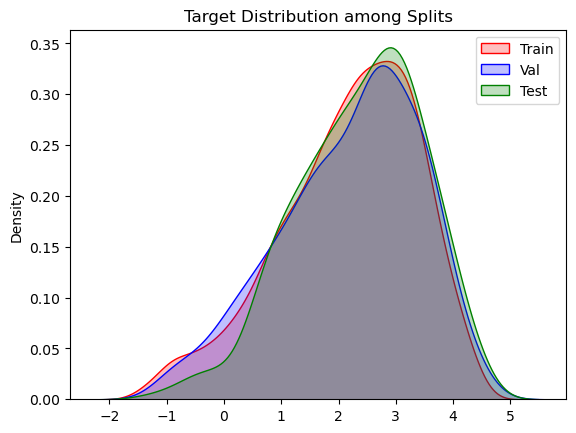

In [158]:
train_labels, val_labels, test_labels = data_dicts['labels']
fig = sns.kdeplot(train_labels, shade=True, color='red', label='Train')
fig = sns.kdeplot(val_labels, shade=True, color='blue', label='Val')
fig = sns.kdeplot(test_labels, shade=True, color='green', label='Test')
plt.title('Target Distribution among Splits')
plt.legend()
plt.show()

세 데이터셋 모두 타겟값의 분포를 보면 __왜도(skewness)가 음수(negative)__ 이며 __최빈값이 약 2~3__ 임을 알 수 있습니다. 따라서 모델 또한 이러한 경향성을 학습하였다는 것을 알 수 있습니다. 

### LightGBM

In [ ]:
lgbm_regressor_params = {'max_depth': 6,
                         'learning_rate': 0.005,
                         'n_estimators': 5000,
                         'objective': 'regression',
                         'reg_lambda': 1.3,
                         'metric' : ['mean_squared_error'],
                         'device_type' : 'gpu'}

lgbm_lipo = LGBMRegressor(random_state=777, **lgbm_regressor_params)
lgbm_lipo.fit(data_dicts['fingerprints'][0], data_dicts['labels'][0], eval_set = [(data_dicts['fingerprints'][1], data_dicts['labels'][1])], verbose=500, early_stopping_rounds=200)

In [39]:
pred = lgbm_lipo.predict(data_dicts['fingerprints'][2])
label = data_dicts['labels'][2]
rmse = mean_squared_error(label, pred, squared=False)
print(f'LGBM Regressor for FreeSolv(expt) | {rmse:.4f}')

LGBM Regressor for FreeSolv(expt) | 0.9207


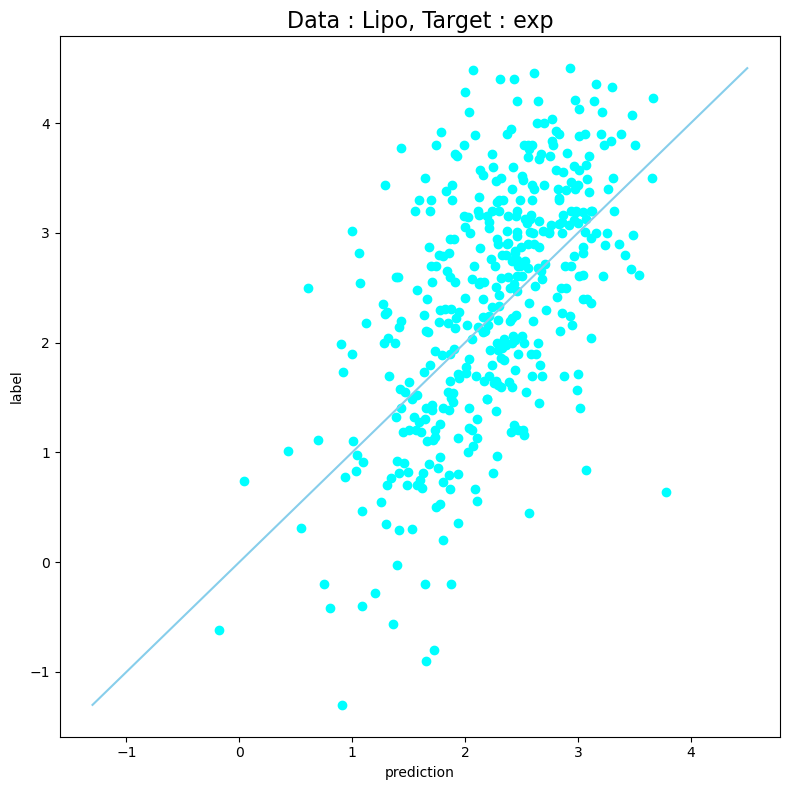

In [40]:
prediction_target_plot(pred, label, data, target)

### CatBoost

In [ ]:
catboost_regressor_params = {'max_depth': 6,
                             'learning_rate': 0.005,
                             'n_estimators': 5000,
                             'l2_leaf_reg': 1.3,
                             'eval_metric' : 'RMSE',
                             'task_type' : 'GPU',
                             'devices':'0'}

cat_lipo = CatBoostRegressor(random_state=777, **catboost_regressor_params)
cat_lipo.fit(data_dicts['fingerprints'][0], data_dicts['labels'][0], eval_set = [(data_dicts['fingerprints'][1], data_dicts['labels'][1])], verbose=500, early_stopping_rounds=200)

In [42]:
pred = cat_lipo.predict(data_dicts['fingerprints'][2])
label = data_dicts['labels'][2]
rmse = mean_squared_error(label, pred, squared=False)
print(f'CatBoost Regressor for FreeSolv(expt) | {rmse:.4f}')

CatBoost Regressor for FreeSolv(expt) | 0.9291


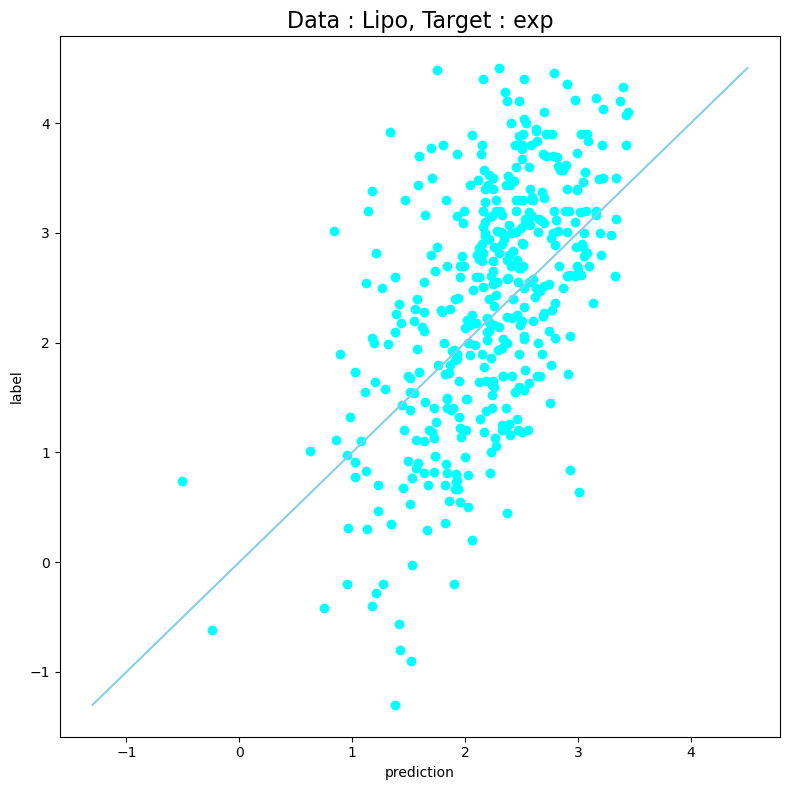

In [43]:
prediction_target_plot(pred, label, data, target)

## Hyper-parameter Tuning

Lipo 데이터에 대해서는 세 모델 모두 평가지표나 시각화 상에서 큰 차이가 없음을 알 수 있습니다. 마지막으로 __5가지 데이터에 대해 하이퍼 파라미터 튜닝을 진행__ 하도록 하겠습니다. __L2 규제화 상수, 학습률, 모델, 트리의 최대 깊이__ 를 바꾸어 가며 각각 __3회__ 씩 반복 실험하였습니다.

In [ ]:
def experiment(data, seed, model, learning_rate, max_depth, l2, **kwargs):
    random.seed(seed)
    np.random.seed(seed)
    config = yaml.load(open(f'./configs/{data}_configs.yaml', 'r'), Loader=yaml.FullLoader)
    
    target_list = TARGET_DICT[data]
    if config['task'] == 'classification':
        postfix = 'Classifier'
        criterion = 'ROC-AUC'
    else:
        postfix = 'Regressor'
        criterion = 'RMSE'
        
    for target in target_list:
        cfg = get_model_config(model, postfix, seed, learning_rate, max_depth, l2, **kwargs)
    
        boosting = globals()[model+postfix](**cfg)
        
        data_dicts = load_data(config['data_path'], target, config['task'])
        train_fps, val_fps, test_fps = data_dicts['fingerprints']
        train_labels, val_labels, test_labels = data_dicts['labels']
        
        boosting.fit(train_fps, train_labels, eval_set = [(val_fps, val_labels)], verbose=500, early_stopping_rounds=200)
        
        if criterion == 'ROC-AUC':
            test_preds = boosting.predict_proba(test_fps)[:, 1]
            value = roc_auc_score(test_labels, test_preds)
        elif criterion == 'RMSE':
            test_preds = boosting.predict(test_fps)
            value = mean_squared_error(test_labels, test_preds, squared=False)
        
        result = {'data':data,
                  'target':target,
                  'seed':seed,
                  'learning_rate':learning_rate,
                  'model':model,
                  'max_depth':max_depth,
                  'l2':l2,
                  'criterion':criterion,
                  'value':value}
        
        df = pd.DataFrame.from_records([result])
        if not os.path.exists('total_result.csv'):
            df.to_csv(os.path.join('total_result.csv'), mode='w', index=False,)
        else:
            df.to_csv(os.path.join('total_result.csv'), mode='a', index=False, header=False)
   
setting_dict = {'seed': [7, 77, 777],
                'learning_rate': [0.001, 0.005, 0.01],
                'max_depth': [6, 8, 12],
                'l2': [0.5, 1.0, 1.5],
                'model': ['XGB', 'LGBM', 'CatBoost'],
                'data': ['BBBP', 'BACE', 'HIV', 'ESOL', 'Lipo']}

params = comb_product(setting_dict)
for param in params:
    experiment(**param)

In [65]:
total_result = pd.read_csv('./total_result.csv')
total_result['Score'] = total_result.apply(lambda x: x['value'] * 100 if x['criterion'] == 'ROC-AUC' else x['value'], axis=1)
summary = total_result.groupby(['learning_rate', 'max_depth', 'l2', 'model', 'data'])['Score'].agg(['mean', 'std']).reset_index()
summary['criterion'] = summary.apply(lambda x: 'ROC-AUC' if x['data'] in ['BACE', 'BBBP', 'HIV'] else 'RMSE', axis=1)
print(summary.head(10).to_markdown())

|    |   learning_rate |   max_depth |   l2 | model    | data   |      mean |         std | criterion   |
|---:|----------------:|------------:|-----:|:---------|:-------|----------:|------------:|:------------|
|  0 |           0.001 |           6 |  0.5 | CatBoost | BACE   | 82.805    | 1.00549     | ROC-AUC     |
|  1 |           0.001 |           6 |  0.5 | CatBoost | BBBP   | 64.1038   | 1.65857     | ROC-AUC     |
|  2 |           0.001 |           6 |  0.5 | CatBoost | ESOL   |  1.74819  | 0.0236358   | RMSE        |
|  3 |           0.001 |           6 |  0.5 | CatBoost | HIV    | 73.5499   | 0.743016    | ROC-AUC     |
|  4 |           0.001 |           6 |  0.5 | CatBoost | Lipo   |  1.00213  | 0.00280442  | RMSE        |
|  5 |           0.001 |           6 |  0.5 | LGBM     | BACE   | 80.1812   | 0           | ROC-AUC     |
|  6 |           0.001 |           6 |  0.5 | LGBM     | BBBP   | 70.4548   | 0           | ROC-AUC     |
|  7 |           0.001 |           6 |  0.5 | 

### Model Roubstness Check with BACE Dataset
BACE 데이터에 대하여 가장 좋았던 모델은 __CatBoost__ 였으며, 학습률은 0.005 max_depth는 8, l2 규제화 상수는 0.5일때 ROC-AUC가 평균 약 84.4로 가장 높았습니다. 가장 낮았던 경우는 XGBoost였으며 최고 성능 대비 약 0.13이나 차이가 나는 것을 알 수 있습니다.

In [162]:
print(summary[summary['data']=='BACE'].sort_values('mean', ascending=False).iloc[[0, -1]].to_markdown())

|     |   learning_rate |   max_depth |   l2 | model    | data   |    mean |      std | criterion   |
|----:|----------------:|------------:|-----:|:---------|:-------|--------:|---------:|:------------|
| 180 |           0.005 |           8 |  0.5 | CatBoost | BACE   | 84.3539 | 0.852861 | ROC-AUC     |
| 100 |           0.001 |          12 |  0.5 | XGB      | BACE   | 71.7754 | 0        | ROC-AUC     |


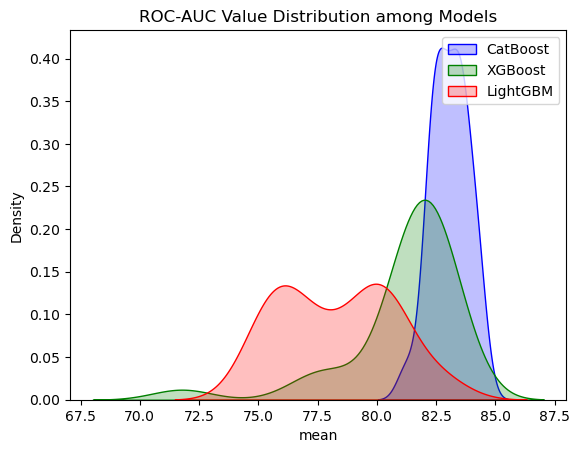

In [166]:
cat_bace_values = summary[(summary['data']=='BACE')&(summary['model']=='CatBoost')]['mean']
xgb_bace_values = summary[(summary['data']=='BACE')&(summary['model']=='XGB')]['mean']
lgbm_bace_values = summary[(summary['data']=='BACE')&(summary['model']=='LGBM')]['mean']
fig = sns.kdeplot(cat_bace_values, shade=True, color='blue', label='CatBoost')
fig = sns.kdeplot(xgb_bace_values, shade=True, color='green', label='XGBoost')
fig = sns.kdeplot(lgbm_bace_values, shade=True, color='red', label='LightGBM')
plt.title('ROC-AUC Value Distribution among Models')
plt.legend()
plt.show()

위 플롯은 통해 하이퍼 파라미터 조합 별로 BACE 데이터에 대해 각 모델의 성능의 분포를 나타냅니다.
__CatBoost 는 하이퍼 파라미터에 상관없이 강건하면서도 높은 성능을 보여주는 반면, LighGBM과 XGBoost는 하이퍼 파라미터 조합에 따라 성능의 편차가 매우 크다__ 라는 것을 알 수 있습니다.

### Model Roubstness Check with BBBP Dataset

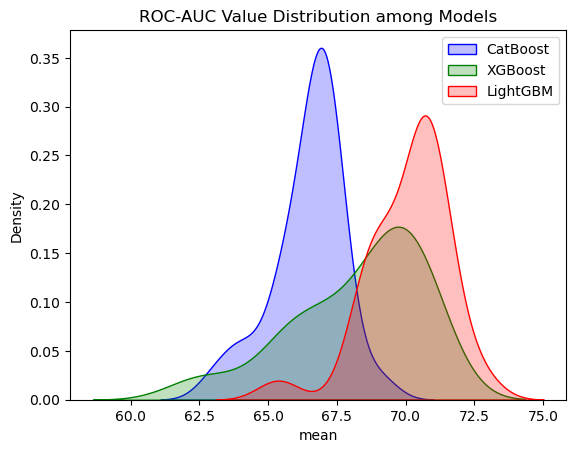

In [167]:
cat_BBBP_values = summary[(summary['data']=='BBBP')&(summary['model']=='CatBoost')]['mean']
xgb_BBBP_values = summary[(summary['data']=='BBBP')&(summary['model']=='XGB')]['mean']
lgbm_BBBP_values = summary[(summary['data']=='BBBP')&(summary['model']=='LGBM')]['mean']
fig = sns.kdeplot(cat_BBBP_values, shade=True, color='blue', label='CatBoost')
fig = sns.kdeplot(xgb_BBBP_values, shade=True, color='green', label='XGBoost')
fig = sns.kdeplot(lgbm_BBBP_values, shade=True, color='red', label='LightGBM')
plt.title('ROC-AUC Value Distribution among Models')
plt.legend()
plt.show()

BBBP 데이터셋에서도 __XGBoost가 하이퍼 파라미터 변화에 가장 민감하다__ 라는 것을 알 수 있습니다. 이번에는 CatBoost가 가장 높은 성능을 나타내진 못했지만, __여전히 CatBoost의 성능 편차가 가장 적다__ 라는 알 수 있습니다.

### Model Roubstness Check with HIV Dataset

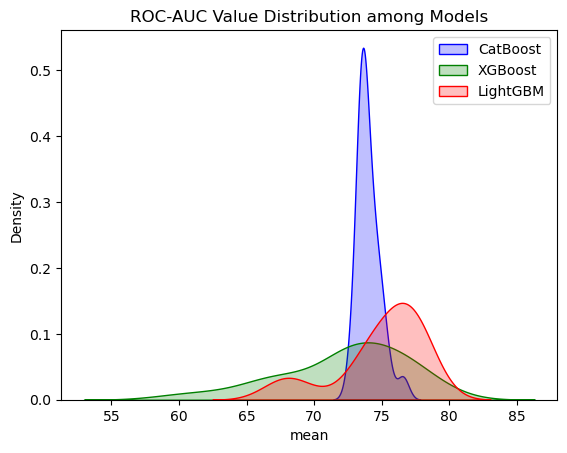

In [168]:
cat_HIV_values = summary[(summary['data']=='HIV')&(summary['model']=='CatBoost')]['mean']
xgb_HIV_values = summary[(summary['data']=='HIV')&(summary['model']=='XGB')]['mean']
lgbm_HIV_values = summary[(summary['data']=='HIV')&(summary['model']=='LGBM')]['mean']
fig = sns.kdeplot(cat_HIV_values, shade=True, color='blue', label='CatBoost')
fig = sns.kdeplot(xgb_HIV_values, shade=True, color='green', label='XGBoost')
fig = sns.kdeplot(lgbm_HIV_values, shade=True, color='red', label='LightGBM')
plt.title('ROC-AUC Value Distribution among Models')
plt.legend()
plt.show()

HIV 데이터에서도 위 두 가지 데이터셋과 마찬가지로 CatBoost가 가장 성능의 변동이 적다는 것을 알 수 있습니다.

### Model Roubstness Check with ESOL Dataset

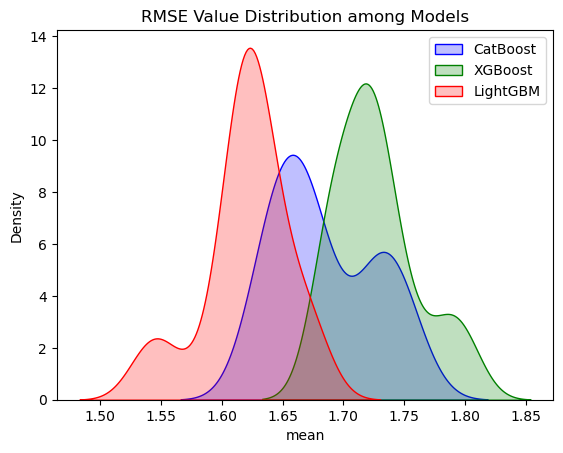

In [171]:
cat_ESOL_values = summary[(summary['data']=='ESOL')&(summary['model']=='CatBoost')]['mean']
xgb_ESOL_values = summary[(summary['data']=='ESOL')&(summary['model']=='XGB')]['mean']
lgbm_ESOL_values = summary[(summary['data']=='ESOL')&(summary['model']=='LGBM')]['mean']
fig = sns.kdeplot(cat_ESOL_values, shade=True, color='blue', label='CatBoost')
fig = sns.kdeplot(xgb_ESOL_values, shade=True, color='green', label='XGBoost')
fig = sns.kdeplot(lgbm_ESOL_values, shade=True, color='red', label='LightGBM')
plt.title('RMSE Value Distribution among Models')
plt.legend()
plt.show()

### Model Roubstness Check with Lipo Dataset

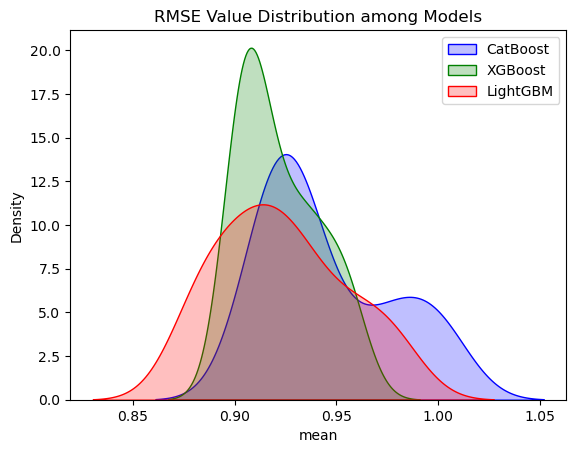

In [172]:
cat_Lipo_values = summary[(summary['data']=='Lipo')&(summary['model']=='CatBoost')]['mean']
xgb_Lipo_values = summary[(summary['data']=='Lipo')&(summary['model']=='XGB')]['mean']
lgbm_Lipo_values = summary[(summary['data']=='Lipo')&(summary['model']=='LGBM')]['mean']
fig = sns.kdeplot(cat_Lipo_values, shade=True, color='blue', label='CatBoost')
fig = sns.kdeplot(xgb_Lipo_values, shade=True, color='green', label='XGBoost')
fig = sns.kdeplot(lgbm_Lipo_values, shade=True, color='red', label='LightGBM')
plt.title('RMSE Value Distribution among Models')
plt.legend()
plt.show()

회귀 데이터인 ESOL와 Lipo에서는 __세 모델의 성능 편차에 대한 우위__ 가 없음을 알 수 있습니다. 플롯에서 시각적으로는 편차가 매우 크게 느껴지지만, Lipo의 경우 다른 모델들 모두 0.85에서 1.05 사이기 때문에 성능 편차가 크다고 보기엔 어렵습니다.